<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/001_TensorFlow_Proj_One_FFNN_RandomSamples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# util
import itertools
import os.path
import numpy as np
from random import randint
# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import (Sequential, load_model)
from tensorflow.keras.layers import (Dense, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (CategoricalCrossentropy, SparseCategoricalCrossentropy)
# matplotlib
import matplotlib.pyplot as plt

In [2]:
# GPU
physical_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
print("No. GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)

No. GPUs available:  1


In [3]:
# generate a train set
train_labels = []
train_samples = []
for i in range(50): # outliers
  random_younger = randint(13, 64)
  train_samples.append(random_younger)
  train_labels.append(1)
  random_older = randint(65, 100)
  train_samples.append(random_older)
  train_labels.append(0)
for i in range(1000): # inliners
  random_younger = randint(13, 64)
  train_samples.append(random_younger)
  train_labels.append(0)
  random_older = randint(65, 100)
  train_samples.append(random_older)
  train_labels.append(1)
# train set
train_labels = np.asarray(train_labels)
train_samples = np.asarray(train_samples)
train_labels, train_samples = shuffle(train_labels, train_samples)

In [4]:
# generate a test case
test_labels = []
test_samples = []
for i in range(10): # outliers
  random_younger = randint(13, 64)
  test_samples.append(random_younger)
  test_labels.append(1)
  random_older = randint(65, 100)
  test_samples.append(random_older)
  test_labels.append(0)
for i in range(200): # inliners
  random_younger = randint(13, 64)
  test_samples.append(random_younger)
  test_labels.append(0)
  random_older = randint(65, 100)
  test_samples.append(random_older)
  test_labels.append(1)
# test set
test_labels = np.asarray(test_labels)
test_samples = np.asarray(test_samples)
test_labels, test_samples = shuffle(test_labels, test_samples)

Text(0, 0.5, 'Categoty')

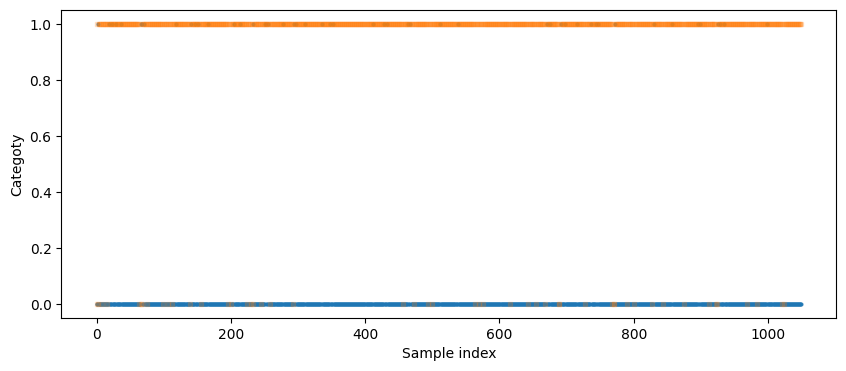

In [5]:
plt.figure(figsize=(10,4))
plt.plot(train_labels[train_samples<65], 'o', markersize=2, alpha=.8)
plt.plot(train_labels[train_samples>=65], 's', markersize=3, alpha=.2)
plt.xlabel("Sample index")
plt.ylabel("Categoty")

Text(0, 0.5, 'Categoty')

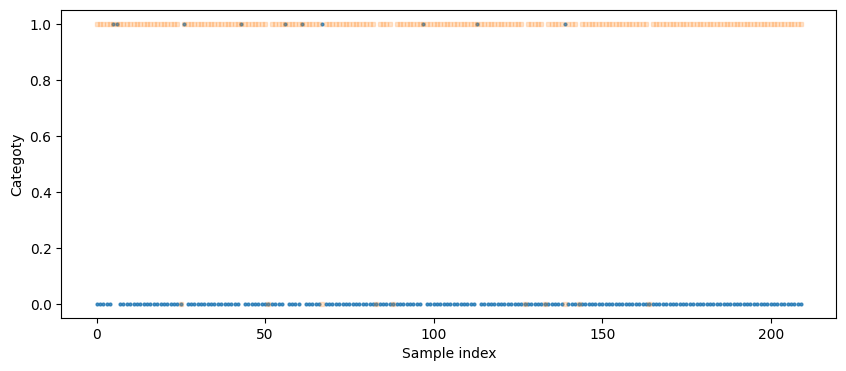

In [6]:
plt.figure(figsize=(10,4))
plt.plot(test_labels[test_samples<65], 'o', markersize=2, alpha=.8)
plt.plot(test_labels[test_samples>=65], 's', markersize=3, alpha=.2)
plt.xlabel("Sample index")
plt.ylabel("Categoty")

In [7]:
# scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_samples = scaler.fit_transform(train_samples.reshape(-1,1))
scaled_test_samples = scaler.transform(test_samples.reshape(-1,1))

In [8]:
# sequential model
model = Sequential(
    [Dense(units=16, input_shape=(1,), activation="relu"),
     Dense(units=32, activation="relu"),
     Dense(units=2, activation="softmax")]
    )
model.summary()
model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"]) # compile
model.fit(x=scaled_train_samples, y=train_labels, batch_size=10, epochs=10, shuffle=True, verbose=2) # fit

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 642 (2.51 KB)

 Trainable params: 642 (2.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
210/210 - 6s - 27ms/step - accuracy: 0.4714 - loss: 0.7031
Epoch 2/10
210/210 - 1s - 3ms/step - accuracy: 0.6033 - loss: 0.6797
Epoch 3/10
210/210 - 1s - 6ms/step - accuracy: 0.6281 - loss: 0.6614
Epoch 4/10
210/210 - 1s - 3ms/step - accuracy: 0.6957 - loss: 0.6384
Epoch 5/10
210/210 - 1s - 4ms/step - accuracy: 0.7224 - loss: 0.6150
Epoch 6/10
210/210 - 1s - 4ms/step - accuracy: 0.7614 - loss: 0.5897
Epoch 7/10
210/210 - 0s - 2ms/step - accuracy: 0.7876 - loss: 0.5625
Epoch 8/10
210/210 - 1s - 2ms/step - accuracy: 0.8124 - loss: 0.5369
Epoch 9/10
210/210 - 1s - 3ms/step - accuracy: 0.8267 - loss: 0.5114
Epoch 10/10
210/210 - 0s - 1ms/step - accuracy: 0.8386 - loss: 0.4864


In [9]:
model.fit(x=scaled_train_samples, y=train_labels, validation_split=0.1,
          batch_size=10, epochs=10, shuffle=True, verbose=2) # fit and validate
pred = model.predict(x=scaled_test_samples, batch_size=100, verbose=2)
pred = np.argmax(pred, axis=-1) # predictions

Epoch 1/10
189/189 - 1s - 5ms/step - accuracy: 0.8561 - loss: 0.4663 - val_accuracy: 0.8714 - val_loss: 0.4317
Epoch 2/10
189/189 - 0s - 2ms/step - accuracy: 0.8582 - loss: 0.4468 - val_accuracy: 0.8857 - val_loss: 0.4097
Epoch 3/10
189/189 - 1s - 4ms/step - accuracy: 0.8677 - loss: 0.4283 - val_accuracy: 0.9048 - val_loss: 0.3886
Epoch 4/10
189/189 - 1s - 3ms/step - accuracy: 0.8847 - loss: 0.4113 - val_accuracy: 0.9048 - val_loss: 0.3694
Epoch 5/10
189/189 - 1s - 6ms/step - accuracy: 0.8878 - loss: 0.3958 - val_accuracy: 0.9238 - val_loss: 0.3516
Epoch 6/10
189/189 - 1s - 3ms/step - accuracy: 0.8947 - loss: 0.3815 - val_accuracy: 0.9238 - val_loss: 0.3352
Epoch 7/10
189/189 - 0s - 3ms/step - accuracy: 0.8926 - loss: 0.3690 - val_accuracy: 0.9286 - val_loss: 0.3201
Epoch 8/10
189/189 - 1s - 3ms/step - accuracy: 0.9032 - loss: 0.3578 - val_accuracy: 0.9286 - val_loss: 0.3074
Epoch 9/10
189/189 - 1s - 3ms/step - accuracy: 0.9032 - loss: 0.3480 - val_accuracy: 0.9381 - val_loss: 0.2952
E

Confusion matrix no normalization
[[188  22]
 [ 10 200]]


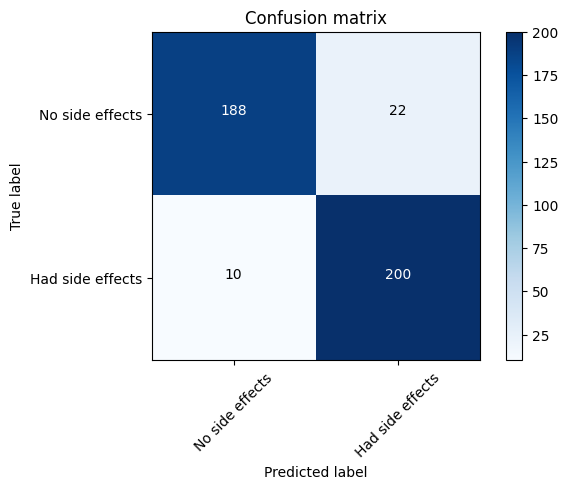

In [10]:
# confusion matrix
def plot_conf_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype("float")/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix no normalization")
  print(cm)
  thresh = cm.max()/2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

cm = confusion_matrix(y_true = test_labels, y_pred = pred)
cm_plot_labels = ["No side effects", "Had side effects"]
plot_conf_matrix(cm=cm, classes=cm_plot_labels)

# if os.path.isfile("model.h5") is False:
#   model.save("model.h5") # # save model, use load_model("model.h5") for loading the model